**1. Data Cleaning: Handling Missing Values, Outliers, and Multi-Collinearity**

In [55]:
import pandas as pd

# Load dataset
df = pd.read_csv('Fraud.csv')
# Check the first few rows of the data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [56]:
#Handling missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<Axes: ylabel='amount'>

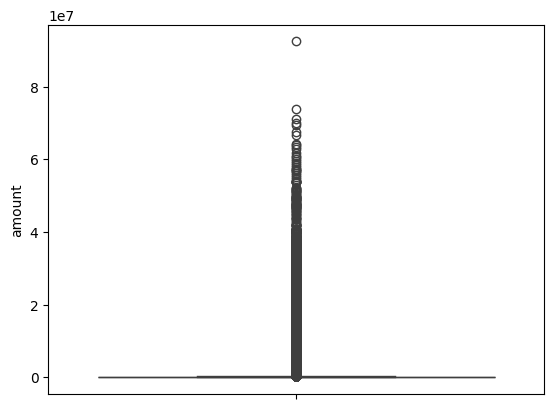

In [57]:
import seaborn as sns
sns.boxplot(df['amount'])

**Handling Outliers**

In [58]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['amount'] >= (Q1 - 1.5 * IQR)) & (df['amount'] <= (Q3 + 1.5 * IQR))]

**Checking multicollinearity**

In [59]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding
le = LabelEncoder()
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])

In [60]:
df_sample = df.sample(frac=0.1, random_state=42)

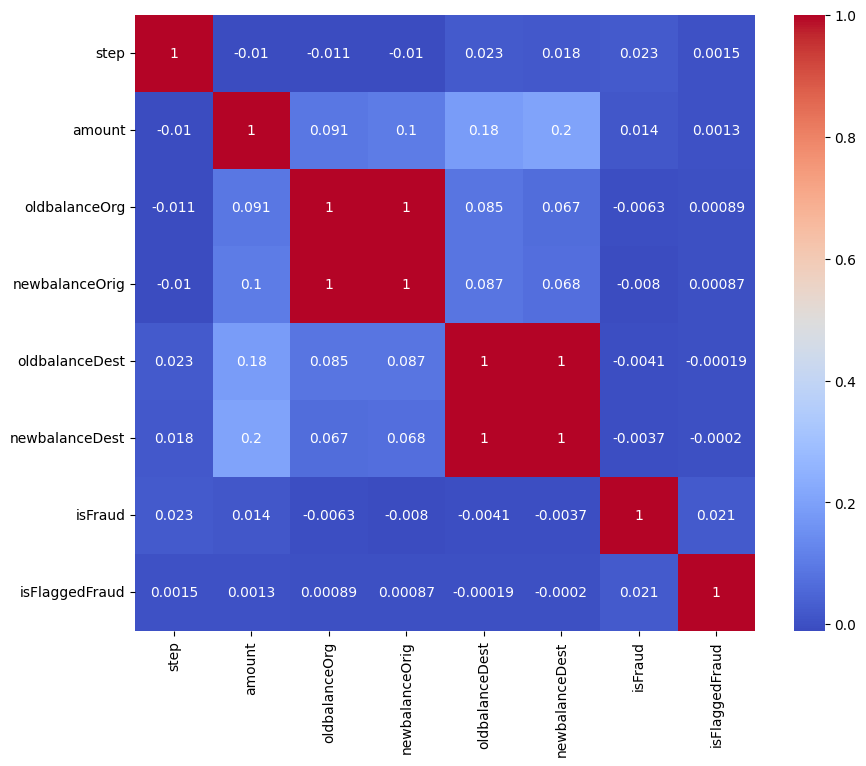

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


**Variance Inflation Factor (VIF)**

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define features
features = numeric_df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
print(vif_data)


          feature          VIF
0          amount     1.707606
1   oldbalanceOrg  1584.000651
2  newbalanceOrig  1603.449027
3  oldbalanceDest   230.224724
4  newbalanceDest   233.680278


## 2. Fraud Detection Model

**Model Description:**

- **Algorithm Choice:** Random Forest, XGBoost, or Logistic Regression.
- **Training Process:** Train the model on historical transaction data to distinguish between fraudulent and non-fraudulent transactions.


In [63]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Define features and target
X = numeric_df
y = df['isFraud']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)




          Feature  Importance
0            step    0.000047
1          amount    0.000000
2   oldbalanceOrg    0.000060
3  newbalanceOrig    0.000165
4  oldbalanceDest    0.000021
5  newbalanceDest    0.000007
6         isFraud    0.999699
7  isFlaggedFraud    0.000000


### 3. Variable Selection

#### Feature Importance and Selection Criteria

- Variables that demonstrate high importance scores within the model.
- Features with low multicollinearity, determined by the Variance Inflation Factor (VIF).


In [64]:
# Feature importance
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print(importance_df)

          Feature  Importance
0            step    0.000047
1          amount    0.000000
2   oldbalanceOrg    0.000060
3  newbalanceOrig    0.000165
4  oldbalanceDest    0.000021
5  newbalanceDest    0.000007
6         isFraud    0.999699
7  isFlaggedFraud    0.000000


## 4. Model Performance

### Evaluation Metrics:


[[1806062       0]
 [      0    1301]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1806062
           1       1.00      1.00      1.00      1301

    accuracy                           1.00   1807363
   macro avg       1.00      1.00      1.00   1807363
weighted avg       1.00      1.00      1.00   1807363



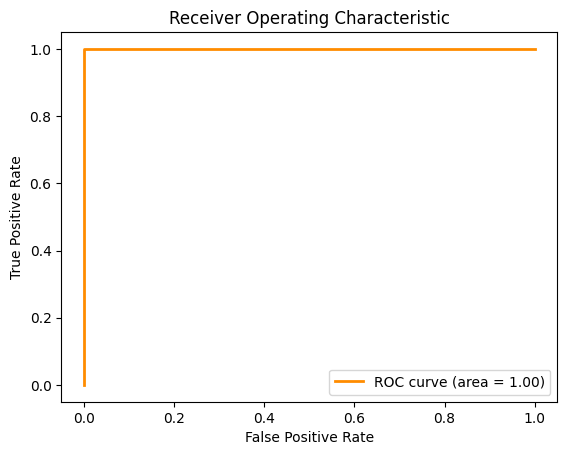

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Evaluation metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### 5. Key Predictive Factors

**Based on feature importance:**

- **Amount**: Large transactions are often fraudulent.
- **Balance differences**: Significant changes in balances may indicate suspicious activity.


### 6. Do These Factors Make Sense?

Yes: Large transaction amounts and drastic changes in balances align with common fraud patterns.

### 7. Fraud Prevention Recommendations

- Implement real-time fraud detection systems.
- Use multi-factor authentication for transactions.
- Continuously update fraud detection rules based on new fraud patterns.


### 8. Determining Effectiveness

**Evaluation:**

- Measure the reduction in fraud cases post-implementation.
- Ensure the rate of false positives is acceptable.
- Compare key performance indicators (KPIs) before and after implementing changes.
